**Get GPU Device Name (If Available)**




In [ ]:
import torch

print(f'GPU Device Name: {torch.cuda.get_device_name()}')

GPU Device Name: Tesla P100-PCIE-16GB


**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install Necesssary Libraries**

In [ ]:
!pip install -q -U split-folders

**Import Libraries**

In [ ]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tensorboard as tb
import splitfolders
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import os

**Import dataset files**

In [ ]:
# unzip zip files of data from google drive
!unzip -q "/content/drive/MyDrive/train_data.zip" -d "/content"
!unzip -q "/content/drive/MyDrive/test_data.zip" -d "/content"

# Split train data into train and val set (final result -> train:val:test = 70:10:20)
splitfolders.ratio("/content/train_data/train_img", "/content",
                seed=1337, ratio=(0.875, 0.125))

# create test folder and import data
!mv "/content/test_data/test_img" "/content"
!mv "/content/test_img" "/content/test"

# remove unnecessary files
!rm -rf "train_data" "test_data" "sample_data"
!rm -rf "/content/test/test_img"

Copying files: 20938 files [00:03, 6586.15 files/s]


**Set device (GPU or CPU)**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Data Augmentation**

In [ ]:
train_transforms = transforms.Compose(
    [
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ]
)

**Set Batch Size**

In [ ]:
# set batch size
batch_size = 128

**Load Datasets**

In [ ]:
# set directories for data
TRAIN_DATA_PATH = "/content/train"
VAL_DATA_PATH = "/content/val"
TEST_DATA_PATH = "/content/test"

# load data for each dataset
train_data = datasets.ImageFolder(root = TRAIN_DATA_PATH, transform=train_transforms)
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

val_data = datasets.ImageFolder(root = VAL_DATA_PATH, transform=test_transforms)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

test_data = datasets.ImageFolder(root = TEST_DATA_PATH, transform=test_transforms)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

**MobileNet v1**

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
class MobileNetV1(nn.Module):
    def __init__ (self, in_channels=3, width_multiplier=1, num_classes=10):
        super(MobileNetV1, self).__init__()
        alpha = width_multiplier

        # Standard CONV
        def conv_std(in_c, out_c, stride):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c*alpha, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_c*alpha),
                nn.ReLU(inplace=True)
            )
        
        # Depthwise Separable CONV
        def conv_dw(in_c, out_c, stride):
            return nn.Sequential(
                nn.Conv2d(in_c*alpha, in_c*alpha, 3, stride, 1, groups=in_c, bias=False),
                nn.BatchNorm2d(in_c*alpha),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_c*alpha, out_c*alpha, 1, 1, 0, bias=False),
                nn.BatchNorm2d(out_c*alpha),
                nn.ReLU(inplace=True)
            )
        
        # 1 standard CONV, 13 depthwise separable CONV
        self.model = nn.Sequential(
            conv_std(in_channels, 32, 2), # standar conv
            conv_dw( 32,  64, 1), # dw1
            conv_dw( 64, 128, 2), # dw2
            conv_dw(128, 128, 1), # dw3
            conv_dw(128, 256, 2), # dw4
            conv_dw(256, 256, 1), # dw5
            conv_dw(256, 512, 2), # dw6
            conv_dw(512, 512, 1), # dw7
            conv_dw(512, 512, 1), # dw8
            conv_dw(512, 512, 1), # dw9
            conv_dw(512, 512, 1), # dw10
            conv_dw(512, 512, 1), # dw11
            conv_dw(512, 1024, 2), # dw12
            conv_dw(1024, 1024, 1), # dw13
            nn.AvgPool2d(7),
        )
        
        # Linear classifier
        self.fc = nn.Linear(1024*alpha, num_classes)
    
    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

    # Kaiming Initialization
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


**Hyperparameters ,Optimizer, and Loss Function**

In [ ]:
learning_rate = 0.001 
num_epochs = 50

model =  MobileNetV1().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

**Torch Summary**

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]           2,048
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
           Conv2d-10           [-1, 64, 56, 56]             576
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]           8,192
      BatchNorm2d-14          [-1, 128,

**Data Structures to Save Data**

In [ ]:
# epoch
epoch_num = [x for x in range(1,num_epochs+1)]

# training accuracy and loss
train_accuracy, total_train_loss = [], []

# validation accuracy and loss
val_accuracy, total_val_loss = [], []

**Model Training (and Val Loop)**

In [ ]:
for epoch in range(num_epochs):
    train_num_correct, train_num_samples = 0, 0
    val_num_correct, val_num_samples = 0, 0

    # training loop
    model.train()
    torch.backends.cudnn.benchmark = True
    tmp_train_loss = []
    for imgs, classes in train_data_loader:
        imgs, classes = imgs.to(device=device), classes.to(device=device)

        output = model(imgs)
        t_loss = loss_func(output, classes)
        tmp_train_loss.append(t_loss.item())

        optimizer.zero_grad()
        t_loss.backward()

        optimizer.step()

        with torch.no_grad():
            scores = model(imgs)
            _, predictions = scores.max(1)

            train_num_correct += (predictions==classes).sum()
            train_num_samples += predictions.size(0)

    train_acc = (train_num_correct)/(train_num_samples)*100
    train_accuracy.append(train_acc.cpu())
    
    tmp_train_loss = np.array(tmp_train_loss)
    epoch_train_loss = np.mean(tmp_train_loss)

    total_train_loss.append(epoch_train_loss)

    # validation loop
    model.eval()
    tmp_val_loss = []
    for imgs, classes in val_data_loader:
        imgs, classes = imgs.to(device=device), classes.to(device=device)

        output = model(imgs)
        v_loss = loss_func(output, classes)
        tmp_val_loss.append(v_loss.item())

        optimizer.zero_grad()
        v_loss.backward()

        optimizer.step()

        with torch.no_grad():
            scores = model(imgs)
            _, predictions = scores.max(1)

            val_num_correct += (predictions==classes).sum()
            val_num_samples += predictions.size(0)
        
    val_acc = (val_num_correct)/(val_num_samples)*100
    val_accuracy.append(val_acc.cpu())

    tmp_val_loss = np.array(tmp_val_loss)
    epoch_val_loss = np.mean(tmp_val_loss)

    total_val_loss.append(epoch_val_loss)

    print(f'Epoch {epoch+1} | Train % = {train_acc} | Val % = {val_acc} | Train loss = {epoch_train_loss} | Val loss = {epoch_val_loss}')

Epoch 1 | Train % = 47.25922775268555 | Val % = 18.268497467041016 | Train loss = 1.8438193077842395 | Val loss = 3.059456847962879
Epoch 2 | Train % = 50.016380310058594 | Val % = 18.154081344604492 | Train loss = 1.6523513346910477 | Val loss = 2.38718695299966
Epoch 3 | Train % = 54.482418060302734 | Val % = 25.705570220947266 | Train loss = 1.5190953819288149 | Val loss = 2.1511932952063426
Epoch 4 | Train % = 60.89757537841797 | Val % = 38.71091079711914 | Train loss = 1.3251684055560164 | Val loss = 1.853589795884632
Epoch 5 | Train % = 68.32823944091797 | Val % = 37.147216796875 | Train loss = 1.1061368075509865 | Val loss = 1.8422229403541202
Epoch 6 | Train % = 75.24022674560547 | Val % = 39.93135070800781 | Train loss = 0.9626049800879426 | Val loss = 1.817368785540263
Epoch 7 | Train % = 78.36863708496094 | Val % = 29.17620277404785 | Train loss = 0.8870640541944239 | Val loss = 2.056942953949883
Epoch 8 | Train % = 81.4369888305664 | Val % = 43.40198516845703 | Train loss =

KeyboardInterrupt: ignored

**Test Set**

In [ ]:
test_num_correct = 0
test_num_samples = 0

model.eval()
with torch.no_grad():
    for img, classes in test_data_loader:
        img, classes = img.to(device=device), classes.to(device=device)

        output = model(img)
        _, predictions = output.max(1)
        test_num_correct += (predictions == classes).sum()
        test_num_samples += predictions.size(0)
    
    print(f'Test Accuracy ----------------------------> {(test_num_correct)/(test_num_samples)*100:.2f}%')

Test Accuracy ----------------------------> 70.81%


**Accuracy Chart (Train and Val)**

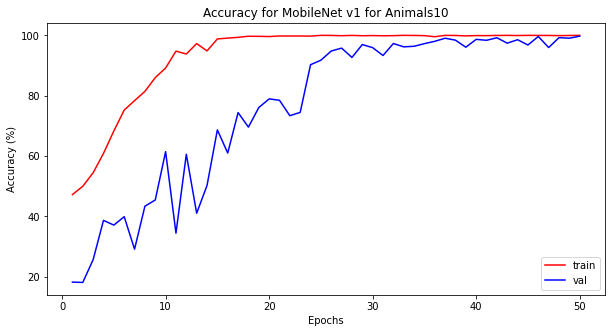

In [ ]:
plt.plot(epoch_num, train_accuracy, 'r', label="train")
plt.plot(epoch_num, val_accuracy, 'b', label="val")
plt.title('Accuracy for MobileNet v1 for Animals10')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.legend(loc="lower right")
#plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

**Loss (Train and Val)**

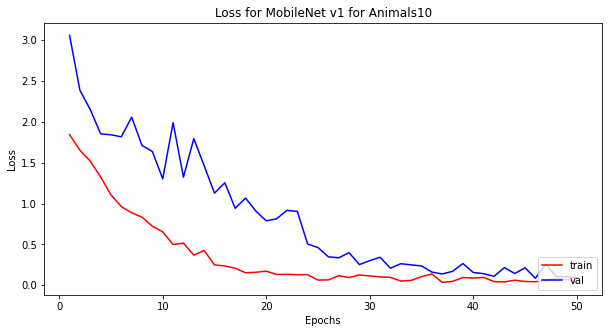

In [ ]:
plt.plot(epoch_num, total_train_loss, 'r', label="train")
plt.plot(epoch_num, total_val_loss, 'b', label="val")
plt.title('Loss for MobileNet v1 for Animals10')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="lower right")
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()